Import Libraries

In [ ]:
import json
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split

Load and Preprocess Data

In [22]:
# Load the dataset and skip problematic rows
try:
    data = pd.read_csv('errors.csv', sep=',', header=0, names=['Words', 'Error Words'], on_bad_lines='skip')
    print(f"Initial dataset size: {data.shape}")
    print(data.head())
except pd.errors.ParserError as e:
    print(f"ParserError: {e}")

# Check for missing values in each column before dropping them
print(f"Missing values in 'Words' column: {data['Words'].isnull().sum()}")
print(f"Missing values in 'Error Words' column: {data['Error Words'].isnull().sum()}")

# Drop rows with missing values in specific columns
data.dropna(subset=['Error Words', 'Words'], inplace=True)
print(f"Dataset size after dropping missing values: {data.shape}")


Initial dataset size: (13958760, 2)
  Words Error Words
0   aah        ahah
1   aah        a ah
2   aah         aqh
3   aah           a
4   aah        aaah
Missing values in 'Words' column: 0
Missing values in 'Error Words' column: 106
Dataset size after dropping missing values: (13958654, 2)


Apply Length Difference Filter

In [23]:
# Filter rows based on length difference criteria
def length_difference(row):
    error_word_length = len(row['Error Words'])
    correct_word_length = len(row['Words'])
    if error_word_length < 3 or correct_word_length < 3:
        return True
    return abs(error_word_length - correct_word_length) / max(error_word_length, correct_word_length) <= 0.4

data = data[data.apply(length_difference, axis=1)]
print(f"Dataset size after applying length difference filter: {data.shape}")


Dataset size after applying length difference filter: (13812475, 2)


Sample Data if Necessary

In [24]:
# Sample 500,000 data points from the dataset if the dataset is large enough
if len(data) > 500000:
    data = data.sample(n=500000, random_state=42)
    print(f"Dataset size after sampling: {data.shape}")
    # Save the sampled data to a CSV file
    data.to_csv('sampled_data.csv', index=False)
    print("Sampled data saved to 'sampled_data.csv'.")
else:
    print(f"Dataset size is less than 500,000, not sampling: {data.shape}")

# Ensure there is data left after filtering
if data.empty:
    raise ValueError("No data left after filtering. Please check the filtering criteria.")


Dataset size after sampling: (500000, 2)


Tokenization and Sequence Conversion

In [25]:
# Prepare the tokenizer
tokenizer = tf.keras.preprocessing.text.Tokenizer(char_level=True)
tokenizer.fit_on_texts(data['Error Words'].astype(str).tolist() + data['Words'].astype(str).tolist())

# Save the tokenizer
tokenizer_json = tokenizer.to_json()
with open('tokenizer.json', 'w') as f:
    f.write(tokenizer_json)

# Save the maxlen
maxlen = max(max(len(seq) for seq in tokenizer.texts_to_sequences(data['Error Words'].astype(str))),
             max(len(seq) for seq in tokenizer.texts_to_sequences(data['Words'].astype(str))))
with open('maxlen.txt', 'w') as f:
    f.write(str(maxlen))

# Convert texts to sequences
X_seq = tokenizer.texts_to_sequences(data['Error Words'].astype(str))
y_seq = tokenizer.texts_to_sequences(data['Words'].astype(str))

# Calculate the maximum length of the sequences
maxlen = max(max(len(seq) for seq in X_seq), max(len(seq) for seq in y_seq))
print(f"Calculated maximum sequence length for padding: {maxlen}")

# Pad the sequences
X_seq_padded = tf.keras.preprocessing.sequence.pad_sequences(X_seq, maxlen=maxlen, padding='post')
y_seq_padded = tf.keras.preprocessing.sequence.pad_sequences(y_seq, maxlen=maxlen, padding='post')


Calculated maximum sequence length for padding: 20


Split Data into Training and Testing Sets

In [26]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_seq_padded, y_seq_padded, test_size=0.1, random_state=42)

# Display shapes of the datasets to verify
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")


X_train shape: (450000, 20)
X_test shape: (50000, 20)
y_train shape: (450000, 20)
y_test shape: (50000, 20)


Define the Model

In [27]:
# Define the enhanced LSTM model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=256, input_length=maxlen),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True)),
    tf.keras.layers.LayerNormalization(),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(len(tokenizer.word_index) + 1, activation='softmax'))
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


C:\Users\PC\PycharmProjects\GrammerAI\venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization             │ ?                      │   0 (unbuilt) │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Create tf.data.Dataset for Efficient Data Loading

In [28]:
# Convert sequences to tf.data.Dataset
def create_dataset(X, y, batch_size=1024):
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    dataset = dataset.shuffle(buffer_size=10000).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

batch_size = 1024
train_dataset = create_dataset(X_train, y_train, batch_size)
test_dataset = create_dataset(X_test, y_test, batch_size)


Train the Model

In [29]:
# Callbacks for training
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)

# Train the model
history = model.fit(train_dataset, validation_data=test_dataset, epochs=20, callbacks=[early_stopping, reduce_lr])


Epoch 1/20
440/440 ━━━━━━━━━━━━━━━━━━━━ 733s 2s/step - accuracy: 0.8143 - loss: 0.7691 - val_accuracy: 0.9176 - val_loss: 0.3343 - learning_rate: 0.0010
Epoch 2/20
440/440 ━━━━━━━━━━━━━━━━━━━━ 687s 2s/step - accuracy: 0.9192 - loss: 0.3267 - val_accuracy: 0.9284 - val_loss: 0.2767 - learning_rate: 0.0010
Epoch 3/20
440/440 ━━━━━━━━━━━━━━━━━━━━ 685s 2s/step - accuracy: 0.9276 - loss: 0.2813 - val_accuracy: 0.9335 - val_loss: 0.2496 - learning_rate: 0.0010
Epoch 4/20
440/440 ━━━━━━━━━━━━━━━━━━━━ 684s 2s/step - accuracy: 0.9319 - loss: 0.2584 - val_accuracy: 0.9369 - val_loss: 0.2341 - learning_rate: 0.0010
Epoch 5/20
440/440 ━━━━━━━━━━━━━━━━━━━━ 703s 2s/step - accuracy: 0.9355 - loss: 0.2409 - val_accuracy: 0.9391 - val_loss: 0.2228 - learning_rate: 0.0010
Epoch 6/20
440/440 ━━━━━━━━━━━━━━━━━━━━ 686s 2s/step - accuracy: 0.9380 - loss: 0.2286 - val_accuracy: 0.9412 - val_loss: 0.2136 - learning_rate: 0.0010
Epoch 7/20
440/440 ━━━━━━━━━━━━━━━━━━━━ 688s 2s/step - accuracy: 0.9403 - loss: 0.

Visualize Training History

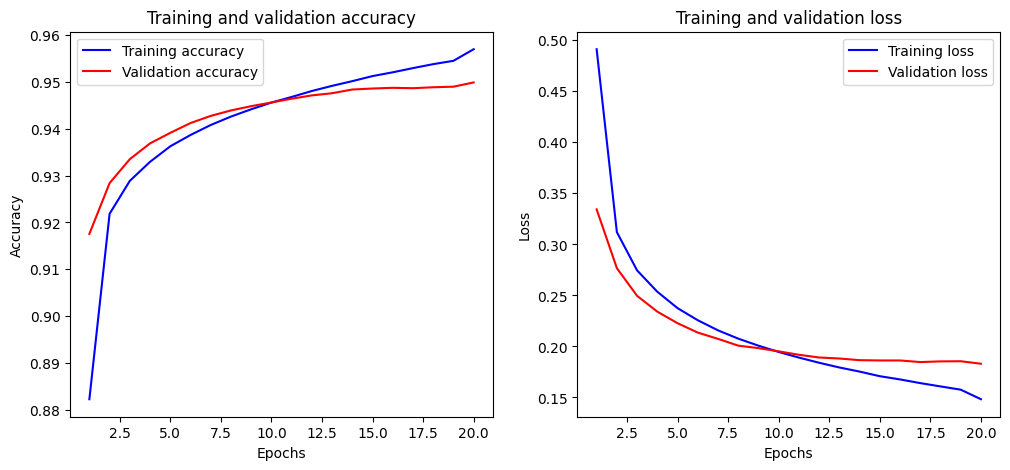

In [30]:
import matplotlib.pyplot as plt

# Function to plot training history
def plot_training_history(history):
    # Extracting values from the history object
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    # Plotting accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plotting loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Plot the training history
plot_training_history(history)


Evaluate the Model on the Test Set

In [31]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


49/49 ━━━━━━━━━━━━━━━━━━━━ 24s 495ms/step - accuracy: 0.9503 - loss: 0.1831
Test Loss: 0.18308261036872864
Test Accuracy: 0.949862003326416


Save Model

In [32]:
# Save the model in Keras format
model.save('word_error_correction_model.h5')